<a href="https://colab.research.google.com/github/louis-perdrix/Modal/blob/main/MTD5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 5: Transformers for computer vision
By Nicolas Dufour, Vicky Kalogeiton and Pascal Vannier

In this TD, we will implement the Transformers architecture. Transformers has been a key architecture in deep learning for the past 5 years. 

It has first began with NLP, then came audio and finally, since 2020, computer vision.
We will implement every block that makes a transformer from scratch and we will try to create a deep understanding of what is happening.
Here is a diagram for the transformer architecture:

<img src="https://www.researchgate.net/profile/Miruna-Gheata/publication/355339249/figure/fig1/AS:1079476452622337@1634378650979/Encoder-decoder-architecture-of-the-Transformer-developed-by-Vaswani-et-al-28.ppm" width=768>

## Instructions
As stated before, in pytorch you must achieve for loops at all cost. It's almost always possible to find a vectorized version of the operation you want to implement.
In this TP, the only for-loop you can do is the training loop.

In [ ]:
!pip install einops
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import math
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import timm



## The Transformer model from the paper Attention is All You Need.

### Attention

The transformer architecture is built around one key block: The attention.
The idea behind attention is the following. Imagine you want to retrieve information from a dictionary. The dictionnary is indexed by keys which maps to a particular value. Now, you have a query which will be matched against the keys of the dict and if you have a match, you will retrieve the associated value.
Attention is very similar to this simple retrieval example. Now, with real data, we don't have this structure, we however are going to learn to create it. 

We have 2 sets of vectors (also named tokens). One is $X_{to}$ which is the destination set. We want to be able to map this set of tokens to queries. We achieve this by doing a linear projection of $X_{to}$. $Q = W_QX_{to}$

The other set is $X_{from}$ the set from which we want to retrieve information. We will need to extract both keys and values from this set. We therefore do 2 linear projections of $X_{from}$. $K = W_KX_{from}$ and $V = W_VX_{from}$.

Now, contrary to the dictionnary where queries and values are exact matchs, we don't have this here. Therefore, we will perform a softer match by computing the similarity matrix between $Q$ and $K$. Then for each $Q$, we want to output the values that have the higher similarity. We therefore output the weighted sum of the values, weighted by the softmax of the similarity (also called the attention matrix).

Finally, the attention operation is given by the cross attention:

$$
A(Q,K,V) = SoftMax(\frac{Q^TK}{\sqrt{d_k}})V
$$

We divide the similarity by $\sqrt{d_k}$ for stability reason to avoid the similarity to explode with big vectors which would lead to very sharp attention coeficients.

##### Question 1:
Implement the attention operation.

Tip: Look into `torch.einsum` to easily compute the similarity matrix.

In [ ]:
class Attention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim,):
        super().__init__()
        self.linq = nn.Linear(x_to_dim, hidden_dim)
        self.link = nn.Linear(x_from_dim, hidden_dim)
        self.linv = nn.Linear(x_from_dim, hidden_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        q = self.linq(x_to)
        k = self.link(x_from)
        v = self.linv(x_from)
        a = torch.einsum('bij, bkj -> bik', q, k)
        a = F.softmax(a/np.sqrt(self.hidden_dim), dim=1)
        x_to = torch.einsum('bij, bjk -> bik', a, v)
        return x_to

In [ ]:
model = Attention(32, 256, 64)
x_to = torch.randn(10, 64, 32)
x_from = torch.randn(10, 32, 256)
x_out = model(x_to, x_from)
assert x_out.shape == torch.Size([10, 64, 64])

#### Multi-head attention

We improve the above attention implementation by introducing mult-head attention. The idea here is that we compute the attention on subspaces of the $Q,K,V$ triplets. 
We split each vector in n subsets and compute the attention for each subset. At the end, we concatenate every attention output and project it with an output projection.

##### Question 2
Implement Multihead attention.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super().__init__()
        #on suppose que hidden_dim/n_heads == 0
        self.linq = nn.Linear(x_to_dim, hidden_dim)
        self.link = nn.Linear(x_from_dim, hidden_dim)
        self.linv = nn.Linear(x_from_dim, hidden_dim)
        self.linout = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.subset = hidden_dim//n_heads


    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        batch_size = x_to.size(0)
        x_to_len = x_to.size(1)
        x_from_len = x_from.size(1)

        q = self.linq(x_to)
        k = self.link(x_from)
        v = self.linv(x_from)
        #on cree les subsets
        q = q.view(batch_size, x_to_len, self.n_heads, self.subset)
        k = k.view(batch_size, x_from_len, self.n_heads, self.subset)
        v = v.view(batch_size, x_from_len, self.n_heads, self.subset)
        #on arrange les dimensions pour compute l'attention
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        a = torch.einsum('bikl, biml -> bikm', q, k)   #[batch_size, n_heads, x_tolen, x_fromlen]
        a = F.softmax(a/np.sqrt(self.subset), dim=1)
        x_to = torch.einsum('bijk, bikl -> bijl', a, v)   #[batch_size, n_heads, x_tolen, x_subset]
        x_to = x_to.transpose(1,2)  #[batch_size, x_to_len, n_heads, x_subset]
        x_to = x_to.reshape(batch_size, x_to_len, self.hidden_dim)
        x_to = self.linout(x_to)
        return x_to

In [ ]:
model = MultiHeadAttention(32, 256, 64, 8)
x_to = torch.randn(10, 64, 32)
x_from = torch.randn(10, 32, 256)
x_out = model(x_to, x_from)
assert x_out.shape == torch.Size([10, 64, 64])

MultiheadAttention is the attention that is used in transformers in pratice. It is used in 2 flavors:
- Self Attention: When $X_{to}$ attends itself ($X_{to}=X_{from}$)
- Cross Attention. $X_{to}\neq X_{from}$


##### Question 3: Implement MultiHead Self Attention and MultiHeadCrossAttention from Multihead attention

In [ ]:
class MultiHeadSelfAttention(MultiHeadAttention):
  def __init__(self, x_to_dim, hidden_dim, n_heads):
    super().__init__(x_to_dim, x_to_dim, hidden_dim, n_heads)

  def forward(self, x_to):
    return super().forward(x_to, x_to)


class MultiHeadCrossAttention(MultiHeadAttention):
  def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
    super().__init__(x_to_dim, x_from_dim, hidden_dim, n_heads)

  def forward(self, x_to, x_from):
    return super().forward(x_to, x_from)

In [ ]:
MultiHeadCrossAttention(3, 4, 6, 2)

MultiHeadCrossAttention(
  (linq): Linear(in_features=3, out_features=6, bias=True)
  (link): Linear(in_features=4, out_features=6, bias=True)
  (linv): Linear(in_features=4, out_features=6, bias=True)
  (linout): Linear(in_features=6, out_features=6, bias=True)
)

### LayerNorm
Another key component of the transformer is the LayerNorm. As we have previously seen, normalizing the output of a deep learning layer helps a lot with convergence and stability. 
Until Transformers, the most used normalization is BatchNorm. We normalize the data among the batch dimension. However, this has a few problems.
- The normalization depend on the other samples in the batch
- When using multiple GPUs, BatchNorm needs to synchronize the batch statistic across GPUs, which locks the forward process and slow down training.

The last element is the most important one. Transformers, aims to be a easy to parralilize architecture and can't afford to use batchnorm.

Instead, Transformers uses Layer Norm. LayerNorm is sample dependent, which removes the synchronization issue. We normalize over the channel dimension instead of the batch dimension.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png">

To account for the loss of capacity, we map the output by a linear transformation with a learned bias and scale.

##### Question 4:
Implement the LayerNorm

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.lin = nn.Linear(output_size, output_size)


  def forward(self, x):
      mean = x.mean(-1, keepdim=True)
      std = x.std(-1, keepdim=True)
      x = (x - mean) / std 
      x = self.lin(x)
      return x

In [ ]:
model = LayerNorm(10)
x = torch.randn(10, 8, 10)
x = model(x)
assert x.shape == torch.Size([10, 8, 10])

### Feed Feedward Network

Finally, the last block is a feed-forward network with one hidden layer. This layer has usually a size of $2 * input\_dim$. This is followed by a dropout layer and an activation function. Here, we will use leaky relu, with a leak parameter of 0.1.
##### Question 5: Implement the FFN layer

In [ ]:
class FFN(torch.nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.1, expansion_factor=2):
        super().__init__()
        self.lin1 = torch.nn.Linear(hidden_dim, 2*hidden_dim)
        self.lin2 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.relu = torch.nn.LeakyReLU(dropout_rate)

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        return x        

In [ ]:
model = FFN(6)
x = torch.randn(10, 8, 6)
x = model(x)
assert x.shape == torch.Size([10, 8, 6])

### The Transformer block

The last thing that we are missing are the skip connection. Like in ResNet, the transformer architecture implements the skip-connection. This allow for a better gradient flow avoiding vanishing gradient.
There is a skip connection after the attention and the feed forward network

##### Question 6.
Looking at the transformer figure, implement the Transformer Encoder Block


In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,data_dim, hidden_dim, n_heads, dropout_rate=0.1):
       super().__init__()
       self.attention_self = MultiHeadSelfAttention(data_dim, hidden_dim, n_heads)
       self.norm = LayerNorm(hidden_dim)
       self.MLP = FFN(hidden_dim, dropout_rate)
    
    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        residual = x
        x = self.attention_self(x) # x = [batch size, x_len, hidden dim]
        x += residual
        x = self.norm(x)
        residual2 = x
        x = self.MLP(x)
        x += residual2
        x = self.norm(x)
        return x


In [ ]:
model = TransformerEncoderBlock(6, 6, 2)
x = torch.randn(10, 8, 6)
x = model(x)
assert x.shape == torch.Size([10, 8, 6])

# Positional embedding
The transformers architecture is permutation independent. That means that for every token, we can swap 2 tokens and have the exact same result. However, the position of the token can be a very important information to consider. Imagine in an image. If a pixel is nearby another pixel, we want the transformer to be able to capture such information. Which is not the case for now.
That's why we introduce positional encodings. For each token, add the positional encoding to the original token:



$X_i = X_i + PE(i)$



with X_i the token at the i dimension.

The most used positional encodings are sinusoidal encodings. They are defined as follow:


$PE(i, 2j) = sin(i / 10000^{\frac{2j}{d}}) $ \\
$PE(i, 2j + 1) = cos(i / 10000^{\frac{2j}{d}})$



Where $d$ the dimension of the tokens, $i$, the i-th token in the sequence and $2j$ (resp $2j + 1$), the index of the dimension of the vector.
The idea here is that we add a sinusoidal that encode the position in a multidimensional array.

Another common positional encodings is the learned positional encoding. Simply, we let the network learn a set of tensor $PE$ that match the sequence length and dimension of the tokens.

##### Question 7. 

Implement both Sinusoidal and Learned positional embeddings

In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim 

    def forward(self, x):
        size = x.size(1) #x [batch, size, hidden_dim]
        #dim = x.size(2)
        pos_enc = torch.zeros(size, self.hidden_dim, dtype=torch.float) #on cree le tableau avec les signatures de position taille [size, hidden_dim]
        # dim ou hidden_dim?
        i = torch.arange(0, size) # on cree un tableau des indices des tokens, taille [size]
        i = i.unsqueeze(1) # taille [size, 1]
        div = torch.exp(torch.arange(0, self.hidden_dim, 2).float() * (-math.log(10000.0) / self.hidden_dim)) # taille [hidden_dim // 2]
        pos_enc[:, ::2] = torch.sin(i*div) # on remplit size * hidden_dim // 2 cases 
        pos_enc[:, 1::2] = torch.cos(i*div) 
        pos_enc = pos_enc.unsqueeze(0) # taille [1, size, hidden_dim] pour l'addition 
        return x + pos_enc # taille [batch, size, dim]

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        self.embedding = nn.Embedding(max_len, hidden_dim)

    def forward(self, x):
        size = x.size(1)
        pos = torch.arange(0, size)
        pos = pos.unsqueeze(0).expand_as(x)
        pos_enc = self.embedding(pos)
        return x + pos_enc


In [ ]:
model = SinusoidalPositionalEncoding(6)
x = torch.randn(10, 8, 6)
x = model(x)
assert x.shape == torch.Size([10, 8, 6])

### The transformer encoder
Now you have everything you need to implement the transformer . You add positional encoding to the tokens and then stack N transformer encoder layers

##### Question 8. 
Implement the transformer encoder with n_layers and the ability to choose both positional embeddings.

Tip: Look into `ModuleList`

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, data_dim,  hidden_dim, n_heads, n_layers, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super().__init__()
        self.encoder = nn.ModuleList([TransformerEncoderBlock(hidden_dim, hidden_dim, n_heads, dropout_rate) for i in range(n_heads)])
        if positional_encoding == "sinusoidal":
          self.pos_encoder = SinusoidalPositionalEncoding(hidden_dim)
        elif positional_encoding == "learned":
          self.pos_encoder = LearnedPositionalEncoding(hidden_dim, max_len)
        self.lin = nn.Linear(data_dim, hidden_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.lin(x)
        x = self.pos_encoder(x)
        for i, encoder in enumerate(self.encoder):
          x = encoder(x)
        return x

In [ ]:
model = TransformerEncoder(8, 6, 2, 5)
x = torch.randn(10, 8, 8)
x = model(x)
assert x.shape == torch.Size([10, 8, 6])

torch.Size([10, 8, 8])
torch.Size([10, 8, 6])
torch.Size([10, 8, 6])
torch.Size([10, 8, 6])
torch.Size([10, 8, 6])


## The Vision Transformer
The above architecture was introduced in 2017 to process sequences of text tokens. However, it could be useful to be able to leverage this architecture for computer vision. On the contrary of convolutional neural network, the transformer has the advantage to introduce less inductive bias.

This could be interesting to leverage to improve vision systems. If we learn the biases from the data, we can hope to have better performances. We however need compute and a lot of data to do this.

To apply the transformer to images, one key question remains to be answered: How do we transform an image to tokens? The approach introduce in Vision Transformers is to cut the image into patches that are then transformed into a token trhought a linear projection.

We also add an extra token, known as the classification token, that will be the token which will be use to predict upon. After going through the N transformer layers, this is the token that goes throught a multi layer perceptron.


<img src= "https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s1600/image1.gif" width="512">


##### Question 9

Implement the vision transformer

Hint: Use Conv2D with the right kernel size and stride to do the linear projection of non-overlapping patches.

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size, hidden_dim, n_heads, n_layers, n_classes, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        if positional_encoding == "sinusoidal":
          self.pos_encoder = SinusoidalPositionalEncoding(hidden_dim)
        elif positional_encoding == "learned":
          self.pos_encoder = LearnedPositionalEncoding(hidden_dim, max_len)
    
    def forward(self, x):
        # x = [batch size, 3, image height, image width]
        x_dim = x.size(1)
        x_batch = x.size(0)
        proj = nn.Conv2d(x_dim, x_dim, kernel_size=self.patch, stride=self.patch) 
        x = proj(x)  
        x = x.flatten(2)  
        x = x.transpose(1, 2) 

        #ajouter le token 0
        token = nn.Parameter(torch.randn(x_batch, 1, x_dim))
        encoder = TransformerEncoder(x_dim, self.hidden_dim, self.n_heads, self.dropout_rate, self.pos_encoder)
        mlp = FFN(self.hidden_dim)

        x = torch.cat((token, x), dim=1)
        x = encoder(x)
        extra = x[:, 0]
        extra = mlp(extra)
        return extra

In [ ]:
ViT(3, 6, 2, 5, 10)

ViT(
  (pos_encoder): SinusoidalPositionalEncoding()
)

### Compact Convolutional Transformer

*   List item

*   List item
*   List item


*   List item


The previous network is a network that need a lot of compute and data to be trained. As we mentionned before, the transformer removes the inductive bias of convnets which requires more data to be tuned.
For this TP, we will try to train an hybrid architecture that preserves the inductive biases of convolution but manages to use the transformer to add global learning.

The first change is the tokenizer. We replace it with a ConvNet. Each convnet layer has a convolution, ReLU and maxpooling.
The second change is to actually remove the classfication token and classify on top of a pooling of all tokens. The pooling is done with an attention like mechanism:
- For each sample, we predict a scalar, that we compute the softmax over all the sample tokens.
- We then do an weighted average pool by this softmax values over the tokens. The weight is given by the previous step

More details see: https://arxiv.org/abs/2104.05704 

<img src= https://miro.medium.com/v2/resize:fit:720/format:webp/1*8diH01Fl7MhHRemLy9hUHw.png width=512>

##### Question 10 
Implement the Convolutional based tokenizer and the SeqPool operationm

In [ ]:
class ConvPatchEmbedding(nn.Module):
    def __init__(self, n_layers, kernel_size, hidden_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = kernel_size, stride = kernel_size)
        #self.conv = nn.Conv2d(in_channels=3 if i == 0 else hidden_dim, hidden_dim, kernel_size, kernel_size//2)
        self.layer = nn.ModuleList([nn.Sequential(nn.Conv2d(
                    in_channels=3 if i == 0 else hidden_dim, 
                    out_channels=hidden_dim, kernel_size=kernel_size, padding=(kernel_size // 2),)
                    , self.relu, self.pool) for i in range(n_layers)])

    def forward(self, x):
        #taille [batch_size, dim, height, width]
        for encoder in self.layer:
          x = encoder(x)
        return x # taille [batch_size, hidden_dim, height // (kernel_size^n_layers), width // (kernel_size^n_layers))]

class SeqPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        scalar = self.lin(x)
        scalar = scalar.squeeze(-1)
        scalar = F.softmax(scalar, dim=1) # [batch, n_sample]

        x = torch.bmm(scalar.unsqueeze(1), x) #[batch, 1, sample]*[batch, sample, dim]
        x = x.squeeze(1) #[batch, dim] 

        return x

##### Question 11

Implement the Compact Convolutional Transformer.

In [85]:
class CCT(nn.Module):
    def __init__(self, n_conv_layers, kernel_size,  n_transformer_layers, hidden_dim, n_heads, n_classes, dropout_rate=0.1):
        super().__init__()
        self.patch = ConvPatchEmbedding(n_conv_layers, kernel_size, hidden_dim)
        self.encoder = TransformerEncoder(hidden_dim, hidden_dim, n_heads, n_transformer_layers, dropout_rate)
        self.classifier = nn.Linear(hidden_dim, n_classes)
        self.pool = SeqPool(hidden_dim)
        self.mlp = FFN(hidden_dim, dropout_rate)
        self.hidden_dim = hidden_dim



    def forward(self, x):
        # x [batch, dim, height, width]
        batch = x.size(0)
        dim = x.size(1)
        #print(x.size())

        x = self.patch(x)
        #print(x.size())
        # # taille [batch_size, hidden_dim, height // (kernel_size^n_layers), width // (kernel_size^n_layers))]

        x = x.permute(0, 2, 3, 1).contiguous() # taille [batch, h', w', hidden_dim]
        #print(x.size())

        x = x.view(batch, -1, self.hidden_dim) # taille [batch, h'*w', hidden_dim]
        #print(x.size())

        x = self.encoder(x)
        # taille [batch, h'*w', hidden_dim]
        #print(x.size())

        x = self.pool(x)
        # taille [batch, hidden_dim]
        #print(x.size())
        x = self.mlp(x)
        # taille [batch, hidden_dim]
        #print(x.size())
        x = self.classifier(x)
        # taille [batch, n_classes]
        #print(x.size())
        return x

In [ ]:
model = CCT(3, 3, 10, 6, 2, 10, 0.1)
x = torch.randn(10, 3, 32, 32)
x = model(x)
assert x.shape == torch.Size([10, 10])

torch.Size([10, 3, 32, 32])
torch.Size([10, 6, 1, 1])
torch.Size([10, 1, 1, 6])
torch.Size([10, 1, 6])
torch.Size([10, 1, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 10])


##### Question 12
Train the CCT on CIFAR-10 for 300 epochs and log both train and test loss and accuracy. You should obtain at least 80+% test accuracy. (Possible to get 90%+). 
We provide a data augmentation strategy called auto augment to avoid overfitting on the training data.
Hparameters are to be choosen to your discretion.

Tips for Hparams:
- Don't use too big of a transformer hidden dim (<256)
- For the convnet, aim to have between 32 and 128 output tokens.
- Use AdamW with some weight decay to avoid overfitting
- Use between 2 and 6 transformer layers.
- Use between 2 and 4 transformer heads

Training takes around 30min (depending of hparams), so keep working on the next questions while it trains. You can copy paste the notebook and run it in a separate collab instance to be able to execute the code of the next questions.

In [ ]:
batch_size = 128
train_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)


100%|██████████| 170498071/170498071 [00:06<00:00, 27681749.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
train_set[0][0].size()

torch.Size([3, 32, 32])

In [96]:
def train(train_loader, test_loader,  epochs=300):
    model = CCT(n_conv_layers = 3, kernel_size = 3, n_transformer_layers = 3, hidden_dim =100 , n_heads = 2, n_classes = 10)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay = 0.01)
    criterion = nn.CrossEntropyLoss()
    model.train()
    train_losses = []
    train_accs = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        train_acc = 0
        for x, y in tqdm(train_loader):
            #x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            #print('heyheyhey',outputs.size())
            #print('yo', y.size())
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #out_pred = outputs>0.5
            out_pred = torch.argmax(outputs) 
            #print(out_pred.size())
            train_acc += (out_pred == y).sum()
            
            


        train_loss /= len(train_loader)
        train_acc = train_acc/ len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

    # Test
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for x, y in test_loader:
            #x, y = x.to(device), y.to(device)
            outputs = model(x)
            #out_pred = outputs>0.5
            out_pred = torch.argmax(outputs) 
            test_acc += (out_pred == y).sum()

    test_acc = test_acc / len(test_loader.dataset)

    return train_losses, train_accs, test_acc

train_losses, train_accs, test_acc = train(train_loader, test_loader, epochs=300)

100%|██████████| 1/1 [03:18<00:00, 198.63s/it]


In [99]:
train_losses, train_accs, test_acc

([2.3064016039719055], [tensor(0.0007)], tensor(0.))

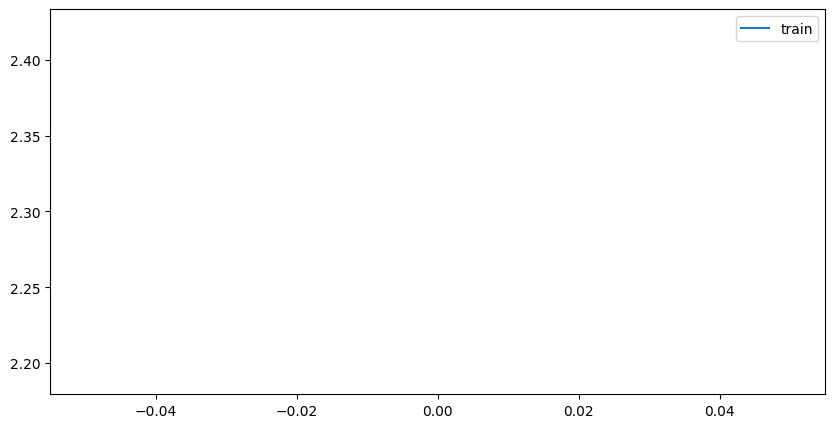

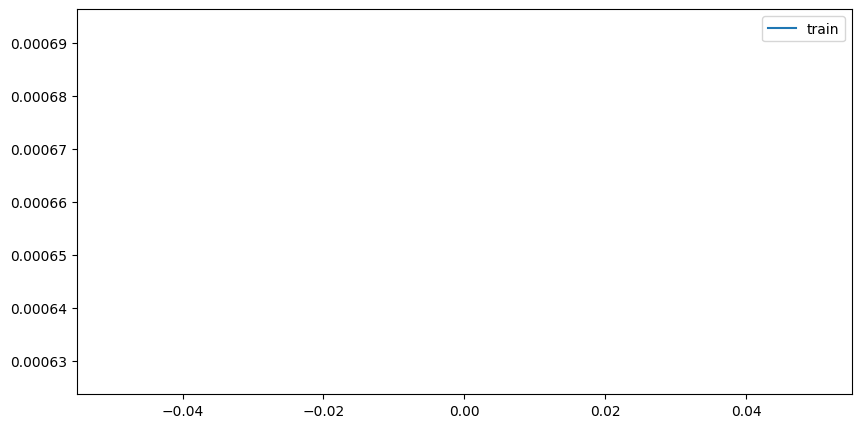

In [98]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="train")
plt.legend()
plt.show()


## What is my transformer doing? Visualizing the attention matrices
Transformers offer a great tool for visualisation. Indeed, we can look at the attention matrices to see what is our attention block looking at. This allows to visualise what data is the transformer paying attention. It could be super useful to identify biases on which the network has been focusing.

Imagine you want to classify dogs and cats, but in your training data dogs always have a red collar. When you use your classifier on a cat with a red collar it classifies it as a dog! Looking at the attention matrix you can see that the transformer just look at the cats collar and doesn't pay attention to cat itself. You just have identified a bias in your data! You can now fix it by collecting data of dogs without collars or of cats with red collars.


The idea here is to look at the attention matrices. We will look into a pretrained ViT called DiNO. Dino has been train with a self-supervised training. We will visualize the attention matrices of this network for some images.

We will use the timm library which has lots of models implemented with pretrained weights.

First let's list all the models that have been trained with the dino procedure:

In [ ]:
timm.list_models('*vit*dino*')

In [ ]:
dino = timm.create_model('vit_base_patch8_224_dino', pretrained=True, img_size=480).eval()

We will use the torchvision to extract the attention matrix. Look at this tutorial on how to extract certain node in the computational network of a model: https://pytorch.org/vision/stable/feature_extraction.html

##### Question 13
First, isolate for each block the name of the node which correspond to the attention matrix.
To guide you, you can look at the Timm library implementation of ViT.

https://github.com/huggingface/pytorch-image-models/blob/7501972cd61dde7428164041b0a6dd8fea60c4d4/timm/models/vision_transformer.py

In [ ]:
# To complete

##### Question 14
Create the feature extractor that outputs all the attention matrices

In [ ]:
# To complete

##### Question 15
Now, find some images online and visualize the attention matrices. Look for images with multiple objects.
We will visualize the matrix corresponding to the class token with all the other tokens. Make sure to reshape them so that they have an image format. Plot every block head attention matrix in a single row. Comment. Plot also the last layer attentions superoposed on the real images.

We provide the code to process the image from an image url.

Tip: For easy reshaping of tensor, look into the `einops` library.

Tip 2: To better visualize the post softmax attention, you can clamp the values and renormalize. Otherwise, a single token can have too much attention and will not allow to visualize the rest of the tokens.

In [ ]:

def get_img_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
    img = img.resize((480, 480))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

In [ ]:
# To complete

In [ ]:
def plot_attn_matrix(attn_matrices):
    # To complete

plot_attn_matrix(attn_matrices)


In [ ]:
# Overlapp the attention matrix with the image (only the last block)
def plot_attn_matrix_with_image(attn_matrices, img):
    # To complete

plot_attn_matrix_with_image(attn_matrices, img)
